# Distracted Driver Detection



    


1. Read and preprocesses data
2. Create model
3. Train model
4. Test model

In [2]:
import cv2
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#from dotenv import load_dotenv

# Preprocessing of Driver Data

In [19]:
#preprocessing class
class PreProcessing:
  """
  Goes through all images, returns preprocessed tensor.
  """

  def __init__(self, base_path):
      self.base_path = base_path
      self.kernel = np.array([[-1, -1, -1],
                   [-1, 8,-1],
                   [-1, -1, -1]])
      print(self.base_path)

  def get_colour_type(self, img_path):
    image = cv2.imread(img_path)
    if len(image.shape) == 3: return 3
    else: return 1

  def preprocess_image(self, img_path, height, width):
    """
    Function takes the path to the image and applys the preprocessing.
    """

    color_type = self.get_colour_type(img_path)

    if color_type == 1:
        img = cv2.imread(img_path, 0)
        img_gray = cv2.threshold(img,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU) 
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)

    elif color_type == 3:
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.threshold(img_gray,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU)
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)
        image_sharp = cv2.cvtColor(image_sharp, cv2.COLOR_BGR2GRAY)
    

    combined = cv2.add(image_sharp, img_gray[1])
    dst = cv2.resize(combined, (width, height))
    dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    
    return dst

  def get_driver_data(self):
    """
    Returns a dictionary of image name as the key and driver and class as value.
    """
    driver_data = {}
    path = os.path.join(self.base_path,'driver_imgs_list.csv')

    print('Read drivers data')

    with open(path, 'r') as file:
      lines = file.readlines()
      lines = lines[1:]
    file.close()

    for line in lines:
      arr = line.strip().split(',')
      driver_data[arr[2]] = (arr[0], arr[1])
    
    return driver_data

  def load_train_data(self, height, width):
    """
    
    """
    x_train = []
    y_train = []
    driver_ids = []

    driver_data = self.get_driver_data()

    print('Read train images')
    for class_number in range(10):
        print(f'Load folder c{class_number}')
        class_number_str = 'c' + str(class_number)
        path = os.path.join(self.base_path, 'imgs/train', class_number_str, '*.jpg')
        file_paths = glob.glob(path)  # Gets all file names matching given path.
        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            image = self.preprocess_image(file_path, height, width)
            x_train.append(image)
            y_train.append(class_number)
            driver_id = driver_data[file_name][0]
            driver_ids.append(driver_id)

    return x_train, y_train, driver_ids

  # Not used since data has no classification
  def load_test_data(self, height, width):
    x_test = []
    x_test_ids = []
    
    print('Read test images')

    path = os.path.join(self.base_path, 'imgs/test/*.jpg')
    file_paths = glob.glob(path)
    number_of_files = len(file_paths)

    for count, file_path in enumerate(file_paths):
        file_name = os.path.basename(file_path)
        image = self.preprocess_image(file_path, height, width)
        x_test.append(image)
        x_test_ids.append(file_name)
        if count % 1000 == 0:
            print(f"Read {count} images from {number_of_files}")

    return x_test, x_test_ids


  def split_train_data(self, x_train, y_train, driver_ids):
    '''
    split the data into train and test sets
    divide data based on driver_ids, this gives the divison of ~73% in train and ~27% in test
    '''
    idList = []
    newTrain_x = []
    newTrain_y = []
    newTest_x = []
    newTest_y = []
    for driver in driver_ids:
        if driver not in idList:
            idList.append(driver)
    trainData = idList[:20]
    testData = idList[20:]
    #iterate trough x_train, compare driver_ids
    for ind in range(len(x_train)):
        if driver_ids[ind] in trainData:
            newTrain_x.append(x_train[ind])
            newTrain_y.append(y_train[ind])
        if driver_ids[ind] in testData:
            newTest_x.append(x_train[ind])
            newTest_y.append(y_train[ind])
    return newTrain_x, newTrain_y, newTest_x, newTest_y


In [20]:
#get processed data
PATH = 'data'
p = PreProcessing(PATH)
x_train, y_train, driver_ids = p.load_train_data(224, 224)
#newTrain_x, newTrain_y, newTest_x, newTest_y = p.split_train_data(x_train, y_train, driver_ids)
#print(len(x_train))
#print(len(newTrain_x) + newTest_x)
#x_test, x_test_id = p.load_test_data(224, 224)

data
Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9


In [44]:
# data visualization
temp = x_train[np.random.randint(0, len(x_train))]
temp = x_train[np.random.randint(0, len(x_train))]
cv2.imshow('image', temp)
cv2.waitKey(0)
cv2.destroyAllWindows

<function destroyAllWindows>

In [52]:
# split train data
newTrain_x, newTrain_y, newTest_x, newTest_y = p.split_train_data(x_train, y_train, driver_ids)
print(len(newTrain_x))
print(len(newTest_x))

# save new train data
# 'TRAIN_PATH'
'''
for img in range(len(newTrain_x)):
    c = newTrain_y[img]
    filename = 'trainImage' + str(img) + '.png'
    directory = r'TRAIN_PATH' + str(c)
    print(directory)
    os.chdir(directory)
    image = newTrain_x[img]
    cv2.imwrite(filename, image)

for img in range(len(newTest_x)):
    c = newTest_y[img]
    filename = 'testImage' + str(img) + '.png'
    directory = r'TEST_PATH' + str(c)
    os.chdir(directory)
    image = newTest_x[img]
    cv2.imwrite(filename, image)
'''


16458
5966


"\nfor img in range(len(newTrain_x)):\n    c = newTrain_y[img]\n    filename = 'trainImage' + str(img) + '.png'\n    directory = r'C:/Users/setcl/Documents/Work/School/5th Year/Fall/Neural & Genetic/Research Project/ppdata/train/' + str(c)\n    print(directory)\n    os.chdir(directory)\n    image = newTrain_x[img]\n    cv2.imwrite(filename, image)\n\nfor img in range(len(newTest_x)):\n    c = newTest_y[img]\n    filename = 'testImage' + str(img) + '.png'\n    directory = r'C:/Users/setcl/Documents/Work/School/5th Year/Fall/Neural & Genetic/Research Project/ppdata/test/' + str(c)\n    os.chdir(directory)\n    image = newTest_x[img]\n    cv2.imwrite(filename, image)\n"

In [5]:
def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation matrices including confusion matrix, accuracy, precision and recall
    
    #initialize confusion matrix
    pass

    ####################################################################################################

## Inception-V3 Model

In [3]:
# define data generators
trainDir = 'TRAIN_PATH'
testDir = 'TEST_PATH'

trainDataGen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255) #, rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, shear_range = 0.2, horizontal_flip = True, fill_mode = 'nearest')
testDataGen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

trainGenerator = trainDataGen.flow_from_directory(trainDir, batch_size = 100, class_mode = 'categorical', target_size = (224, 224))
testGenerator = testDataGen.flow_from_directory(testDir, batch_size = 100, class_mode = 'categorical', target_size = (224, 224))

Found 16458 images belonging to 10 classes.
Found 5966 images belonging to 10 classes.


In [4]:
# callback to stop training at certain threshold
class myCallback(keras.callbacks.Callback):
    
    # change cause won't ever happen
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('acc') > 0.99 and logs.get('val_acc') > 0.99):
            print('\nCancelling training as model reached 99 accuracy and 99 validation acc.')
            self.model.stop_training == True


In [5]:
# plot results
def plotResult(history):
    acc = history.history['accuracy']
    valAcc = history.history['val_accuracy']
    loss = history.history['loss']
    valLoss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
    plt.plot(epochs, valAcc, 'b', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc = 0)
    plt.figure()
    plt.show()

In [7]:
# CNN model
width, height = 224, 224

inputShape = (width, height, 3)

inputLayer = keras.layers.Input(shape = inputShape)
outputLayer = keras.layers.Dense(10, activation = 'softmax')

x = keras.layers.Conv2D(32, (2, 2), activation = 'relu')(inputLayer)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)

x = keras.layers.Conv2D(32, (2, 2), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)

x = keras.layers.Conv2D(64, (2, 2), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(1024, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputLayer = keras.layers.Dense(10, activation = 'softmax')(x)

#if input_tensor

cnnModel = keras.Model(inputs = inputLayer, outputs = outputLayer)
cnnModel.compile(optimizer = keras.optimizers.RMSprop(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
#cnnModel.summary()
#keras.utils.plot_model(cnnModel, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [8]:
# train/fit model
callbacks = myCallback()
history = cnnModel.fit(x = trainGenerator, validation_data = testGenerator, validation_freq = 1, epochs = 10, verbose = 1) #steps_per_epoch = 100, validation_steps = 100, callbacks = [callbacks]

Epoch 1/10
165/165 [==============================] - 369s 2s/step - loss: 1.7775 - accuracy: 0.4201 - val_loss: 1.7368 - val_accuracy: 0.4286
Epoch 2/10
165/165 [==============================] - 389s 2s/step - loss: 0.6890 - accuracy: 0.8227 - val_loss: 1.6319 - val_accuracy: 0.4616
Epoch 3/10
165/165 [==============================] - 371s 2s/step - loss: 0.2519 - accuracy: 0.9403 - val_loss: 1.9486 - val_accuracy: 0.4262
Epoch 4/10
165/165 [==============================] - 373s 2s/step - loss: 0.1055 - accuracy: 0.9747 - val_loss: 1.9124 - val_accuracy: 0.4893
Epoch 5/10
165/165 [==============================] - 371s 2s/step - loss: 0.0521 - accuracy: 0.9875 - val_loss: 2.7470 - val_accuracy: 0.4780
Epoch 6/10
165/165 [==============================] - 359s 2s/step - loss: 0.0336 - accuracy: 0.9916 - val_loss: 2.5227 - val_accuracy: 0.4638
Epoch 7/10
165/165 [==============================] - 391s 2s/step - loss: 0.0193 - accuracy: 0.9947 - val_loss: 2.5516 - val_accuracy: 0.4899

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


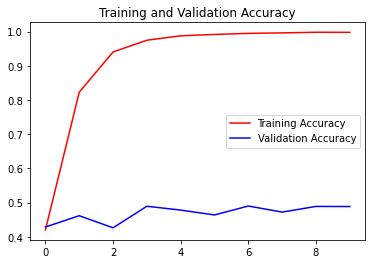

<Figure size 432x288 with 0 Axes>

In [9]:
# plot training and results
print(history.history.keys())
plotResult(history)

In [10]:
# Import InceptionV3 and perform transfer learning
from keras.applications.inception_v3 import InceptionV3
preTrainedModel = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in preTrainedModel.layers:
    layer.trainable = False

preTrainedModel.summary()

# add dense layers after pretrained model
lastLayer = preTrainedModel.get_layer('mixed7')
lastOutput = lastLayer.output

x = keras.layers.Flatten()(lastOutput)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(10, activation = 'softmax')(x)

model = keras.Model(preTrainedModel.input, x)
model.compile(optimizer = keras.optimizers.RMSprop(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()




87924736/87910968 [==============================] - 24s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_6[0][0]']               
 alization)          

In [11]:
# Train/fit InceptionV3 model
inceptionHistory = cnnModel.fit(x = trainGenerator, validation_data = testGenerator, validation_freq = 1, epochs = 10, verbose = 1)

Epoch 1/10
  7/165 [>.............................] - ETA: 3:54 - loss: 0.0087 - accuracy: 0.9971

KeyboardInterrupt: 

In [ ]:
# plot results
#print(history.history.keys())
plotResult(inceptionHistory)

In [11]:
#plot results
'''
        plt.plot(model1.history['train_acc'], label='train_acc')
        plt.plot(model1.history['test_acc'], label='test_acc')
        plt.legend()
        plt.show()
'''


"\n        plt.plot(model1.history['train_acc'], label='train_acc')\n        plt.plot(model1.history['test_acc'], label='test_acc')\n        plt.legend()\n        plt.show()\n"

In [12]:
#predict
#y_pred = model1.predict(x_test)
#evaluator(y_test, y_pred)